# MSE flux in THAI experiments (early attempts)

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Standard library
from pathlib import Path

# Data analysis and viz libraries
import dask
import dask.array as da
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
# Local modules
from calc import (
    hdiv,
    integral,
    mass_weighted_vertical_integral,
    moist_static_energy,
    vert_mer_mean_of_mse_flux,
)
from grid import (
    EARTH_RADIUS,
    meridional_mean,
    reverse_along_dim,
    roll_da_to_0360,
    roll_da_to_pm180,
    zonal_mean,
)
from load_thai import LOAD_CONF
from model_exocam import calc_alt_exocam, calc_pres_exocam
from model_lmdg import calc_alt_lmdg, calc_virtual_temp_lmdg
from model_um import calc_um_ocean_frac
from names import exocam, lmdg, rocke3d, um

In [4]:
import mypaths

## Choose case

In [5]:
THAI_case = "Ben1"

## Constants

Define atmospheric and planetary constants. Note the planet's radius is in meters!

In [6]:
if THAI_case.endswith("1"):
    import const_ben1_hab1 as const
else:
    import const_ben2_hab2 as const

## Loading the data

Lazily load all data into one dictionary.

In [7]:
# Load data
datasets = {}  # Create an empty dictionary to store all data
# Loop over THAI cases (this loop can swapped places with the loop below if needed)
for THAI_case in [THAI_case]:
    # for each of the THAI cases, create a nested directory for models
    datasets[THAI_case] = {}
    for model_key in LOAD_CONF.keys():
        datasets[THAI_case][model_key] = LOAD_CONF[model_key]["loader"](THAI_case)

## Diagnostics and plots

### ExoCAM

In [8]:
# Prepare variables
model_key = "ExoCAM"
ds = datasets[THAI_case][model_key].isel(
    **{
        # Choose only the last chunk for now
        # exocam.t: slice(-61, None),
        # Discard rows close to poles
        exocam.y: slice(1, -1),
        # (Optional, change 2nd None to turn it on) Discard upper atmosphere levels
        exocam.lev: slice(None, None),
        "ilev": slice(None, None),
    }
)
temp_ExoCAM = ds.T
press_ExoCAM = calc_pres_exocam(ds)
rho_ExoCAM = press_ExoCAM / (const.rgas * temp_ExoCAM)
u_ExoCAM = ds.U
v_ExoCAM = ds.V
q_ExoCAM = ds.Q
alt_ExoCAM = calc_alt_exocam(
    ds,
    mw_ratio=const.mw_ratio,
    dry_air_gas_constant=const.rgas,
    condens_gas_constant=const.rvapor,
    gravity=const.gplanet,
)

In [9]:
kw_const = dict(
    c_p=const.c_p,
    gravity=const.gplanet,
    latent_heat=const.latent_heat,
    r_planet=const.rplanet_m,
)

In [10]:
# mse_flx_hdiv_parts_by_press = vert_mer_mean_of_mse_flux(
#     u_ExoCAM,
#     v_ExoCAM,
#     temp=temp_ExoCAM,
#     alt=alt_ExoCAM,
#     zcoord=press_ExoCAM,
#     zcoord_type="pressure",
#     lon_name=exocam.x,
#     lat_name=exocam.y,
#     z_name=exocam.lev,
#     cmpnt="dry",
#     **kw_const
# )

In [17]:
mse_flx_hdiv_parts_by_height = vert_mer_mean_of_mse_flux(
    u_ExoCAM,
    v_ExoCAM,
    temp=temp_ExoCAM,
    alt=alt_ExoCAM,
    zcoord=press_ExoCAM,
    rho=rho_ExoCAM,
    zcoord_type="pressure",
    lon_name=exocam.x,
    lat_name=exocam.y,
    z_name=exocam.lev,
    cmpnt="dry",
    opt="finite_diff",
    **kw_const
)

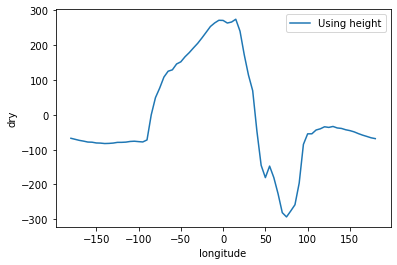

In [18]:
# mse_flx_hdiv_parts_by_press.dry.mean(exocam.t).plot(label="Using pressure")
mse_flx_hdiv_parts_by_height.dry.mean(exocam.t).plot(label="Using height")
plt.legend()

## ROCKE3D

In [13]:
model_key = "ROCKE3D"
ds = datasets[THAI_case][model_key].isel(
    **{
        # Choose only the last chunk for now
        rocke3d.t: slice(None, None),
        # Discard rows close to poles
        rocke3d.y: slice(1, -1),
        # Discard upper atmosphere levels
        rocke3d.lev: slice(None, None),
    }
)
lat_ROCKE3D = ds[rocke3d.y]
lon_ROCKE3D = ds[rocke3d.x]
tsurf_ROCKE3D = ds.tgrnd + 273.15  # temperature in C
ps_ROCKE3D = ds.p_surf


temp_ROCKE3D = ds.t
u_ROCKE3D = ds.u
v_ROCKE3D = ds.v
w_ROCKE3D = ds.w
alt_ROCKE3D = ds.z
press_ROCKE3D = ds.p_3d * 100  # (mb to Pa)
rho_ROCKE3D = press_ROCKE3D / (const.rgas * temp_ROCKE3D)

In [14]:
mse_flx_hdiv_parts = vert_mer_mean_of_mse_flux(
    u_ROCKE3D,
    v_ROCKE3D,
    temp=temp_ROCKE3D,
    alt=alt_ROCKE3D,
    zcoord=alt_ROCKE3D,
    rho=rho_ROCKE3D,
    zcoord_type="height",
    lon_name=rocke3d.x,
    lat_name=rocke3d.y,
    z_name=rocke3d.lev,
    cmpnt="dry",
    **kw_const
)

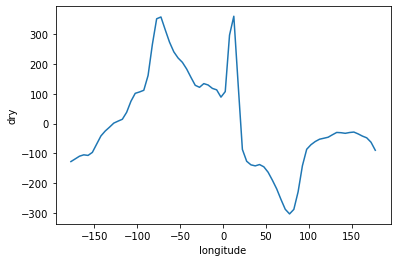

In [15]:
mse_flx_hdiv_parts.dry.mean(rocke3d.t).plot()

### UM

In [16]:
# Prepare variables
model_key = "UM"
ds = datasets[THAI_case][model_key].isel(
    **{
        # Choose only the last chunk for now
        um.t: slice(None, None),
        # Discard rows close to poles
        um.y: slice(1, -1),
        # Discard upper atmosphere levels
        # um.z: slice(None, -5),
    }
)
temp_UM = ds[um.temp]
u_UM = ds[um.u]
v_UM = ds[um.v]
press_UM = ds[um.pres]
# q_UM = ds[um.sh]
alt_UM = ds[um.z]
rho_UM = press_UM / (const.rgas * temp_UM)

In [19]:
with dask.config.set(**{"array.slicing.split_large_chunks": False}):
    mse_flx_hdiv_parts = vert_mer_mean_of_mse_flux(
        u_UM,
        v_UM,
        temp=temp_UM,
        alt=alt_UM,
        rho=rho_UM,
        zcoord_type="height",
        lon_name=um.x,
        lat_name=um.y,
        z_name=um.z,
        cmpnt="dry",
        **kw_const
    )

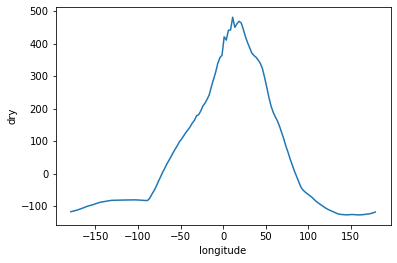

In [20]:
mse_flx_hdiv_parts.dry.mean(um.t).plot()